# N-Body Quadtree Tutorial

In this tutorial, we will use the `NbodyQuadTree` submodule in `astroQTpy` to create a stability map of a two planet system using `REBOUND` (see full docs [here](https://rebound.readthedocs.io/en/latest/)). As a starting point, we will closely follow [this REBOUND example](https://rebound.readthedocs.io/en/latest/ipython_examples/Megno/), which implements the chaos indicator MEGNO (Mean Exponential Growth of Nearby Orbits) and the symplectic integrator WHFast (Rein and Tamayo 2015). Then, we will create a similar stability map using a quadtree data structure implemented in `astrQTpy`.

### Brute Force Stability Map

Following the example linked above, we will integrate a two planet system with massive planets. We vary the semi-major axis $a$ (in AU) and the eccentricity $e$. First, we'll define a function that runs one simulation for a given set of initial conditions $(a, e)$.

In [1]:
import rebound
import numpy as np

def megno_whfast_simulation(par):
    
    a, e = par # unpack parameters
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.ri_whfast.safe_mode = 0
    sim.dt = 5.
    sim.add(m=1.) # Star
    sim.add(m=0.000954, a=5.204, M=0.600, omega=0.257, e=0.048) # Planet inner
    sim.add(m=0.000285, a=a, M=0.871, omega=1.616, e=e) # Planet outer
    sim.move_to_com()
    
    sim.init_megno()
    sim.exit_max_distance = 20.
    
    try:
        sim.integrate(1e4 * 2.*np.pi, exact_finish_time=0) # integrate for 10000 years, integrating to the nearest
        # timestep for each output to keep the timestep constant and preserve WHFast's symplectic nature
        megno = sim.calculate_megno() 
        return megno
    
    except rebound.Escape:
        return 50. # At least one particle got ejected, returning large MEGNO.

Try this out by running one simulation:

In [2]:
megno_whfast_simulation((7,0.1))

2.0217103387201414

The returned value is the MEGNO, which in this case is about 2. According to the example linked above, this indicates that the system is regular for these initial conditions. Next, we'll run a whole array of simulations. For a fair comparison, we'll run everything on just a single processor for now.

In [3]:
Ngrid = 64
par_a = np.linspace(7., 10., Ngrid)
par_e = np.linspace(0., 0.5, Ngrid)

parameters = []
for e in par_e:
    for a in par_a:
        parameters.append((a, e))
        
results = list(map(megno_whfast_simulation, parameters))
results2d = np.array(results).reshape(Ngrid, Ngrid)

On a single core on my laptop, this takes approximately 35 seconds.

Now we'll plot the results.

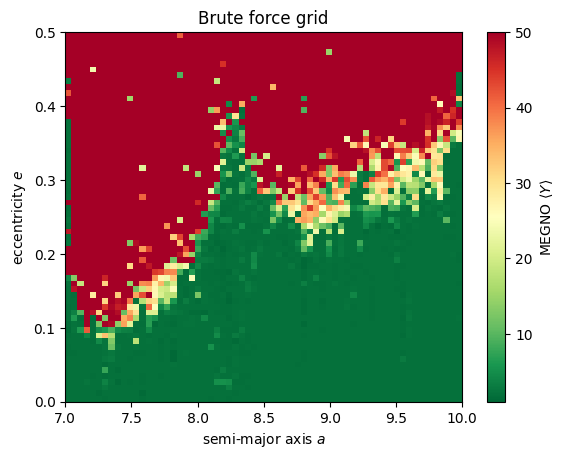

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_title('Brute force grid')

extent = [min(par_a),max(par_a),min(par_e),max(par_e)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel("semi-major axis $a$")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel("eccentricity $e$")

im = ax.imshow(results2d, interpolation="none", vmin=1, vmax=50, cmap="RdYlGn_r", origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label("MEGNO $\\langle Y \\rangle$"); 

### Quadtree Stability Map with `astroQTpy`

Our brute force method of running a simulation at every grid point can be optimized with a quadtree. This should eliminate the need to calculate excess models where the MEGNO value isn't changing much, for example in the green and red areas. The quadtree will automatically start to explore a finer grid where the MEGNO value changes significantly, hopefully improving our code's efficiency.

Let's import `NbodyQuadTree` submodule from `astroQTpy`.

In [5]:
from astroqtpy.quadtree import NbodyQuadTree

And now define the limits of the paramter space we want to explore.

In [6]:
x_min, x_max = 7, 10  # semi-major axis
y_min, y_max = 0, 0.5  # eccentricity

Next we create an instance of `NbodyQuadTree`, entering in the limits of the desired parameter space and our function for running a `REBOUND` simulation. We can further specify the split threshold, or the criterion for making the grid resolution finer by splitting a parent node into four children. In this example, we've set this value such that a node will split if the difference between its MEGNO value and one of its neighbors is greater than 0.5.

For this example, we will only run a single simulation in each node, although we may wish to run many simulations and average their MEGNO values them to improve the accuracy of our results. Finally, we set the maximum depth to 7, allowing for a maximum grid size of 64 x 64 (2^(7-1) = 64).

In [7]:
nbody_tree = NbodyQuadTree(x_min, x_max, y_min, y_max, megno_whfast_simulation,
                           split_threshold=0.5,
                           N_points=1,
                           N_proc=1,
                           max_depth=7,
                           verbose=False,
                           filename_points='./tutorial_outputs/nbodytree_points.txt',
                           filename_nodes='./tutorial_outputs/nbodytree_nodes.txt'
                           )

Run the quadtree! (Note that astroQTpy will attempt to autoload any saved results before running more simulations.)

In [8]:
nbody_tree.run_quadtree()

Attempting to load previous results...
   No previous results found, starting new...
DONE! :)


This only took about 20 seconds on a single core on my laptop.

Now let's plot the results and check that we get a consistent stability map with the brute force method.

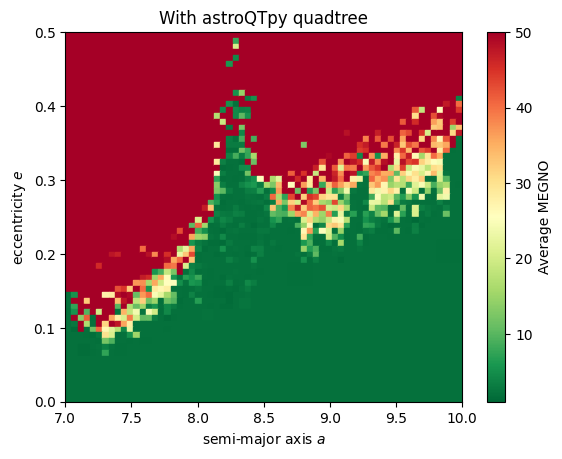

In [9]:
# make figure
fig, ax = plt.subplots()
ax.set_title('With astroQTpy quadtree')
quadtree_map = nbody_tree.draw_tree(ax, vmin=1, vmax=50, show_lines=False)
plt.colorbar(quadtree_map, ax=ax, label='Average MEGNO')
ax.set_xlabel("semi-major axis $a$")
ax.set_ylabel("eccentricity $e$")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max); 

Our results are consistent! While the runtime speed up in this example is modest, we would expect much better performace compared to the brute force method when simulations take longer to compute and we want to run many simulations within each node of the quadtree.

Finally, let's get a closer look at how this stability map is generated by showing the node borders and simulation points.

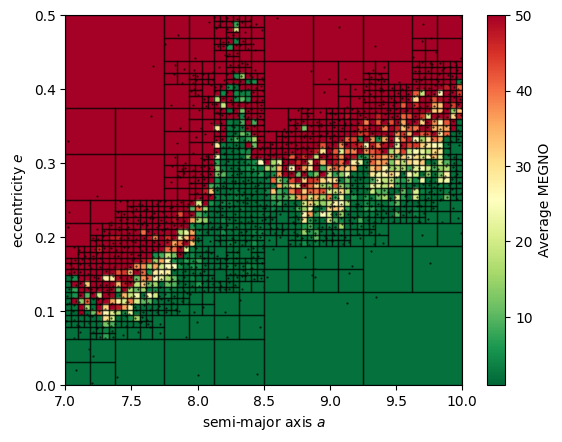

In [10]:
# make figure
fig, ax = plt.subplots()
quadtree_map = nbody_tree.draw_tree(ax, vmin=1, vmax=50, show_lines=True, show_points=True)
plt.colorbar(quadtree_map, ax=ax, label='Average MEGNO')
ax.set_xlabel("semi-major axis $a$")
ax.set_ylabel("eccentricity $e$")
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max); 